In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.mask as rio_mask

import matplotlib.pyplot as plt

In [2]:
root_dir = Path().resolve().parent
data_path = root_dir / "data"
output_path = root_dir / "output_data"

geotiff_inundaciones_filename = data_path / "CdJuarez_60min" / "CdJuarez_60Min_Reclass.tif"

In [3]:
df_agebs = (
    gpd.read_file(data_path / "08.2.03.gpkg")
    # .drop(columns=["POBTOT"])
    .set_index("CVEGEO")
)

df_blocks = (
    gpd.read_file(data_path / "08m" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda x: x.CVEGEO.str[:13])
    .query("CVEGEO_AGEB in @df_agebs.index")
    # .drop(columns=["CVEGEO_AGEB"])
    .drop(columns=["CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "CVE_MZA", "AMBITO", "TIPOMZA"])
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)

In [4]:
df_census = (
    pd.read_csv(
        data_path / "ageb_mza_urbana_08_cpv2020/conjunto_de_datos_ageb_urbana_08_cpv2020.csv",
        usecols=["ENTIDAD", "MUN", "LOC", "AGEB", "MZA", "POBTOT", "P_60YMAS"],
    ).assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
            + df["MZA"].astype(str).str.zfill(3)
        ),
    )
    .set_index("CVEGEO")
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "MZA"])
    .replace(["*", "N/D"], np.nan)
    # .astype(float)
)

df_blocks_extended = df_blocks.join(df_census[["POBTOT"]])

In [5]:
%%time

# Threshold to consider flooding
FLOODED_INT_THRESHOLD = 5  # corresponds to 0.25
PIXEL_AREA = 4.80696110271104814675

is_flooded = {}

# area_flooded = {}
# The area flooded doesn't behave too well because the pixels can cover more than the geometry

with rio.open(geotiff_inundaciones_filename) as ds:
    df_reprojected = df_blocks_extended.to_crs(ds.crs)

    for idx, geom in df_reprojected["geometry"].items():
        masked, transform = rio_mask.mask(ds, [geom], crop=True)
        
        pixels_considered_flooded = masked > FLOODED_INT_THRESHOLD
        
        is_flooded[idx] = pixels_considered_flooded.any()
        # area_flooded[idx] = np.minimum(1, np.sum(pixels_considered_flooded) * PIXEL_AREA / geom.area)  # sum of pixel area can be larger than 1

df_blocks_extended = (
    df_blocks_extended
        .assign(is_flooded=pd.Series(is_flooded))
        # .assign(area_flooded=pd.Series(area_flooded))
)

CPU times: user 5.87 s, sys: 437 ms, total: 6.31 s
Wall time: 6.43 s


<Axes: xlabel='is_flooded'>

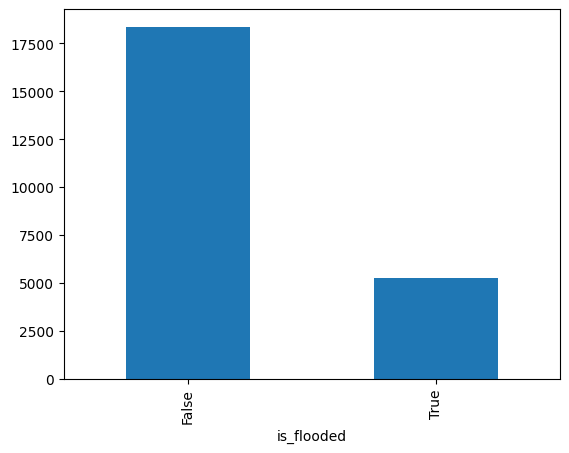

In [6]:
df_blocks_extended["is_flooded"].value_counts().plot.bar()

In [7]:
# Add column "POB_AFECTADA" considering that if a neighbourhood floods even somewhat then
# the whole population is affected

# We group only the flooded neighbourhoods by AGEB, and use reindex to align the codes.
idx_is_flooded = df_blocks_extended.is_flooded
gby = df_blocks_extended.loc[idx_is_flooded].groupby("CVEGEO_AGEB")

ageb_pop_affected = (
    gby["POBTOT"]
    .sum()
    .reindex(df_agebs.index, fill_value=0)
)

df_agebs = df_agebs.assign(POB_AFECTADA=ageb_pop_affected)

In [8]:
# Add the column "PORCENTAJE_POB_AFECTADA"

# We need to avoid division by 0
idx_has_pop = df_agebs["POBTOT"] > 0

pctg_affected = 100 * df_agebs.loc[idx_has_pop, "POB_AFECTADA"] / df_agebs.loc[idx_has_pop, "POBTOT"]
pctg_affected = (
    pctg_affected
    .round(2)
    .reindex(df_agebs.index, fill_value=0)
)

df_agebs = df_agebs.assign(PORCENTAJE_POB_AFECTADA=pctg_affected)

In [10]:
%%time

## Add the column "PORCENTAJE_AREA_INUNDADA" directly from the AGEBs without using neighbourhoods

area_flooded = {}

with rio.open(geotiff_inundaciones_filename) as ds:
    df_projected = df_agebs.to_crs(ds.crs)

    for idx, geom in df_projected["geometry"].items():
        masked, transform = rio_mask.mask(ds, [geom], crop=True)
        
        pixels_considered_flooded = masked > FLOODED_INT_THRESHOLD
        area_flooded[idx] = 100 * np.minimum(1, np.sum(pixels_considered_flooded)  * PIXEL_AREA / geom.area)  # sum of pixel area can be larger than 1

df_agebs = (
    df_agebs
        .assign(PORCENTAJE_AREA_INUNDADA=pd.Series(area_flooded).round(2))
)

CPU times: user 2.15 s, sys: 479 ms, total: 2.63 s
Wall time: 2.66 s


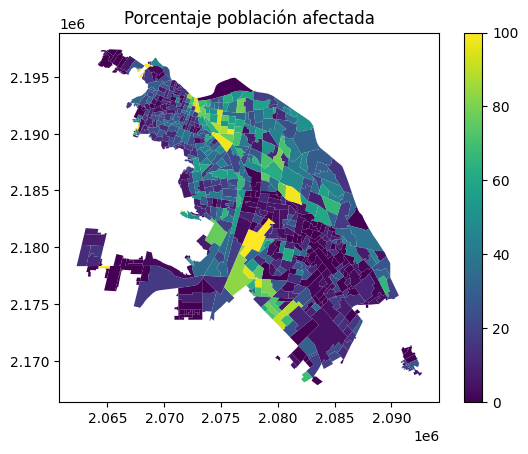

In [11]:
fig, ax = plt.subplots()
df_agebs.plot("PORCENTAJE_POB_AFECTADA", legend=True, ax=ax)
ax.set_title("Porcentaje población afectada");

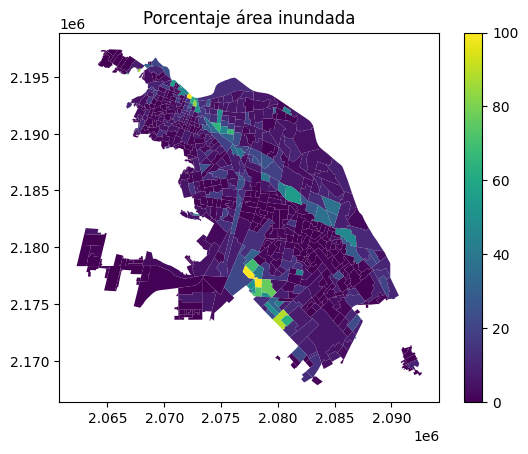

In [12]:
fig, ax = plt.subplots()
df_agebs.plot("PORCENTAJE_AREA_INUNDADA", legend=True, ax=ax)
ax.set_title("Porcentaje área inundada");